# Analyses post scrapping

Objectifs :
- on veut surveiller le nombre de concurrents
- ceux qui arrivent à vendre
- ceux qui changent de stratégie

In [154]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [124]:
villes = ['Arcueil', 'Bourg-la-Reine', 'Cachan']
ma_description = 'Appartement entier calme pour JO 2024'
df = pickle.load(open('tous_les_logements.p', 'rb')).drop('texte', axis=1)
df = df[df.ville.isin(villes)].copy()

# On supprime ce logement, car il est enregistré avec 2 et avec 3 chambres à la fois :
df = df.query('description != "La maison de l’Éléphant"')

# Cet exemple montre qu'on a des doublons parfaits :
df[(df.description == 'Summer 2023 Cheerful 3-bedroom family home')]
clé = ['type', 'ville', 'description']
# Validation de la clé :
df = df.drop_duplicates(['date_enregistrement'] + clé)

# À une date d'enregistrement donné, ce qui fait l'unicité d'un logement est la combinaison
# de variables suivantes :
test = df.groupby(['date_enregistrement'] + clé).prix.nunique()
assert (test != 1).sum() == 0

def assigne_identifiant_logement(df, clé):
    """Assigne des id_logements"""
    mapping = df[clé].drop_duplicates().assign(id_logement=lambda df: range(1, len(df) + 1))
    mapping.loc[mapping.description == ma_description, 'id_logement'] = 0  # je me garde l'id 0 pour moi
    result = pd.merge(
        df, mapping, how='left', on=clé, validate='many_to_one'
    )
    result.insert(0, 'id_logement', result.pop('id_logement'))
    return result
df = assigne_identifiant_logement(df, clé)
clé = ['id_logement'] + clé
print(df.shape)
df.tail(2)

(655, 12)


,id_logement,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
653,145,2024-03-10,Chambre,Arcueil,Séjournez chez Virginie Et FrançoisSéjournez c...,896,4.93,30.0,NaN,NaN,False,False
654,109,2024-03-10,Hébergement,Bourg-la-Reine,Belle maison proche Paris,878,NaN,NaN,NaN,NaN,False,True


In [125]:
# Nombre de concurrents
df.groupby(['date_enregistrement', 'ville']).date_enregistrement.count().to_frame().unstack().T

date_enregistrement                 2023-12-20  2023-12-25  2024-01-06  \
                    ville                                                
date_enregistrement Arcueil                  6          15          17   
                    Bourg-la-Reine           8          10           7   
                    Cachan                  34          32          34   

date_enregistrement                 2024-01-13  2024-01-25  2024-01-31  \
                    ville                                                
date_enregistrement Arcueil                  6          15          16   
                    Bourg-la-Reine           5           6           7   
                    Cachan                  39          33          38   

date_enregistrement                 2024-02-10  2024-02-18  2024-02-24  \
                    ville                                                
date_enregistrement Arcueil                 20           9           6   
                    Bourg-la-Reine           6           1           2   
                    Cachan                  37          37          37   

date_enregistrement                 2024-03-02  2024-03-10  
                    ville                                   
date_enregistrement Arcueil                 25          32  
                    Bourg-la-Reine           7          12  
                    Cachan                  46          50

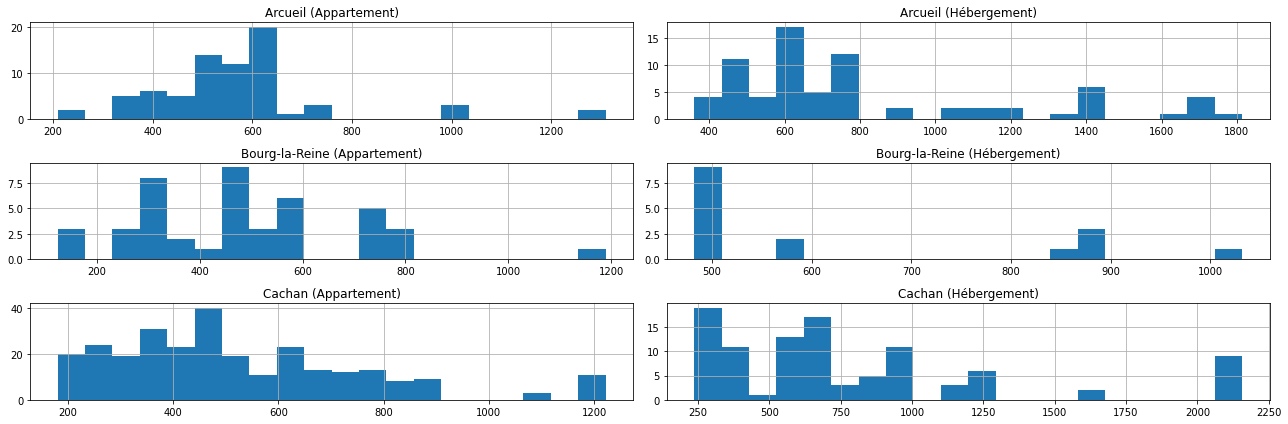

In [126]:
fig = plt.figure(figsize=(18, 6))
num_plot = 1
for ville in villes:
    vue = df[df.ville == ville]
    for type_ in ('Appartement', 'Hébergement'):
        fig.add_subplot(len(villes), 2, num_plot)
        plt.title(f'{ville} ({type_})')
        vue[vue.type == type_].prix.hist(bins=20)
        num_plot += 1
plt.tight_layout()

In [127]:
# Être nouveau augmente les prix
df.groupby('est_nouveau').prix.mean()

est_nouveau
False    609.562617
True     642.091667
Name: prix, dtype: float64

In [128]:
# Être professionnel aussi
df.groupby('est_professionnel').prix.mean()

est_professionnel
False    610.246305
True     685.369565
Name: prix, dtype: float64

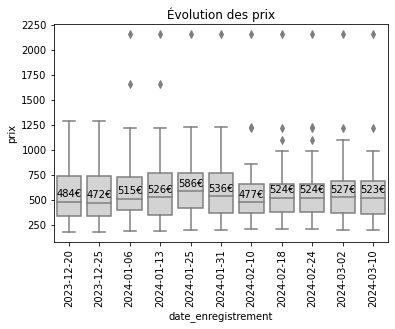

In [129]:
# Comment évoluent les prix ?
import seaborn as sns
vue = df[df.ville == 'Cachan']


sns.boxplot(x=vue.date_enregistrement, y=vue.prix, color='lightgray')
médianes = vue.groupby('date_enregistrement').prix.median()
for i, médiane in enumerate(médianes):
    plt.text(i, médiane + 50, f'{médiane:.0f}€', ha='center')
plt.xticks(rotation=90)
plt.title('Évolution des prix');

## Suivi des logements dans le temps

In [130]:
df.sample(3)

,id_logement,date_enregistrement,type,ville,description,prix,note,nb_avis,nb_lits,nb_chambres,est_professionnel,est_nouveau
605,24,2024-03-10,Appartement,Cachan,L'appartement de Cachan,367,NaN,NaN,NaN,NaN,False,False
355,101,2024-02-10,Appartement,Cachan,Appartement 3 chambres/5 pièces,524,NaN,NaN,NaN,NaN,False,False
423,86,2024-02-18,Appartement,Cachan,"Logement 80m2,parking gratuit,Paris 5min envoi...",862,4.53,57.0,4.0,2.0,False,False


In [170]:
def make_pivot(df):
    pivot = df.pivot(columns=['date_enregistrement'], values='prix', index=clé)
    pivot.columns = list(pivot.columns)
    pivot = pivot.reset_index()

    # Creation de la dernière date connue :
    date_cols = pivot.filter(regex='202').columns.tolist()
    pivot['dernier_prix_connu'] = pivot.filter(regex="202").ffill(axis=1).iloc[:, -1]
    
    pivot['dernière_date_connue'] = np.nan
    for col in date_cols[::-1]:
        cond = pivot['dernière_date_connue'].isnull()
        cond &= pivot[col].notnull()
        pivot.loc[cond, 'dernière_date_connue'] = col
        
    pivot['première_date_connue'] = np.nan
    for col in date_cols:
        cond = pivot['première_date_connue'].isnull()
        cond &= pivot[col].notnull()
        pivot.loc[cond, 'première_date_connue'] = col
    return pivot
pivot = make_pivot(df)
pivot.head()

,id_logement,type,ville,description,2023-12-20,2023-12-25,2024-01-06,2024-01-13,2024-01-25,2024-01-31,2024-02-10,2024-02-18,2024-02-24,2024-03-02,2024-03-10,dernier_prix_connu,dernière_date_connue,première_date_connue
0,0,Appartement,Cachan,Appartement entier calme pour JO 2024,NaN,472.0,504.0,474.0,474.0,474.0,474.0,474.0,474.0,474.0,474.0,474.0,2024-03-10,2023-12-25
1,1,Appartement,Cachan,Appt 2 chambres proche Paris!,278.0,278.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,2024-03-10,2023-12-20
2,2,Appartement,Cachan,"Appartement 86m2, 6p, 3km Paris",494.0,494.0,526.0,526.0,526.0,NaN,NaN,NaN,NaN,NaN,NaN,526.0,2024-01-25,2023-12-20
3,3,Hébergement,Cachan,Charming Family French Home with Private Garden!,1290.0,1290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1290.0,2023-12-25,2023-12-20
4,4,Villa,Cachan,Jardin fleuri tout près de Paris,916.0,916.0,831.0,831.0,831.0,NaN,NaN,NaN,NaN,NaN,NaN,831.0,2024-01-25,2023-12-20


In [182]:
concat = pd.concat([
    pivot.première_date_connue.value_counts().sort_index().to_frame().T,
    pivot.dernière_date_connue.value_counts().sort_index().to_frame().T,
], axis=0)
concat.index = ['première_date_connue', 'dernière_date_connue']
concat

,2023-12-20,2023-12-25,2024-01-06,2024-01-13,2024-01-25,2024-01-31,2024-02-10,2024-02-18,2024-02-24,2024-03-02,2024-03-10
première_date_connue,48,15,22,6,7,12,16,5,2,15,20
dernière_date_connue,4,14,8,9,8,5,9,2,3,12,94


In [132]:
def cachanais_qui_ont_lair_davoir_loué(pivot, df, nb=2):
    """Ils n'apparaissent plus depuis `nb` scrapings"""
    last_cols = pivot.columns[-nb:].tolist()
    cond = pivot[last_cols].isnull().sum(axis=1) == nb
    loués = pivot[cond & (pivot.ville == 'Cachan')]
    print(loués.shape, "rdx")
    result = pd.merge(
        loués,
        df.loc[df.nb_chambres.notnull(), ['id_logement', 'nb_chambres']].drop_duplicates(),
        on=['id_logement'], how='left', validate='many_to_one'
    )
    result.insert(3, 'nb_chambres', result.pop('nb_chambres'))
    return result
loués = cachanais_qui_ont_lair_davoir_loué(pivot, df)
loués

(29, 15) rdx


,id_logement,type,ville,nb_chambres,description,2023-12-20,2023-12-25,2024-01-06,2024-01-13,2024-01-25,2024-01-31,2024-02-10,2024-02-18,2024-02-24,2024-03-02,2024-03-10
0,2,Appartement,Cachan,3.0,"Appartement 86m2, 6p, 3km Paris",494.0,494.0,526.0,526.0,526.0,NaN,NaN,NaN,NaN,NaN,NaN
1,3,Hébergement,Cachan,NaN,Charming Family French Home with Private Garden!,1290.0,1290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,Villa,Cachan,3.0,Jardin fleuri tout près de Paris,916.0,916.0,831.0,831.0,831.0,NaN,NaN,NaN,NaN,NaN,NaN
3,5,Appartement,Cachan,2.0,T3 Cosy N°5 proche Paris,851.0,851.0,883.0,883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,Appartement,Cachan,2.0,"Appartement proche Paris, commerces et transports",315.0,315.0,340.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,7,Appartement,Cachan,2.0,Le contemporain - T3 - Paris - RER B-Cachan - ...,592.0,592.0,624.0,624.0,624.0,624.0,NaN,NaN,NaN,NaN,NaN
6,9,Appartement,Cachan,2.0,Le Perfectionniste - spacieux logement terrass...,734.0,734.0,766.0,766.0,766.0,NaN,NaN,NaN,NaN,NaN,NaN
7,15,Appartement,Cachan,2.0,Joli 3 pièces à 10 min de Paris,391.0,391.0,476.0,302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,16,Appartement,Cachan,NaN,Appartement 6 invités à 25 min du centre de Paris,473.0,473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,17,Hébergement,Cachan,NaN,Summer 2023 Cheerful 3-bedroom family home,340.0,340.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
def cachanais_qui_ont_modifié_leur_prix(pivot):
    changeurs = pivot[pivot.filter(regex='202').nunique(axis=1) > 1]
    return changeurs
cachanais_qui_ont_modifié_leur_prix(pivot)

,id_logement,type,ville,description,2023-12-20,2023-12-25,2024-01-06,2024-01-13,2024-01-25,2024-01-31,2024-02-10,2024-02-18,2024-02-24,2024-03-02,2024-03-10
0,0,Appartement,Cachan,Appartement entier calme pour JO 2024,NaN,472.0,504.0,474.0,474.0,474.0,474.0,474.0,474.0,474.0,474.0
1,1,Appartement,Cachan,Appt 2 chambres proche Paris!,278.0,278.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
2,2,Appartement,Cachan,"Appartement 86m2, 6p, 3km Paris",494.0,494.0,526.0,526.0,526.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Villa,Cachan,Jardin fleuri tout près de Paris,916.0,916.0,831.0,831.0,831.0,NaN,NaN,NaN,NaN,NaN,NaN
5,5,Appartement,Cachan,T3 Cosy N°5 proche Paris,851.0,851.0,883.0,883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,121,Appartement,Cachan,Le Contemporain T3/Proche Paris/RER B à 200 mè...,NaN,NaN,NaN,NaN,NaN,NaN,624.0,624.0,624.0,369.0,835.0
122,123,Appartement,Bourg-la-Reine,Appartement 2 pièces avec parking à 15mn de Paris,NaN,NaN,NaN,NaN,NaN,NaN,370.0,NaN,314.0,314.0,314.0
126,127,Appartement,Arcueil,"Studio 40m2, 4 personnes max",NaN,NaN,NaN,NaN,NaN,NaN,474.0,NaN,474.0,360.0,360.0
128,129,Appartement,Bourg-la-Reine,Chez Léna et Robin : Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN,NaN,295.0


In [ ]:
todo : faire un ffill sur les y ci-dessous :
        car quand on a un trou au milieu, c'est que je n'ai pas scrapé ces logements.
        
todo : 
    faire un gif semaine après semaine du graphique dessous

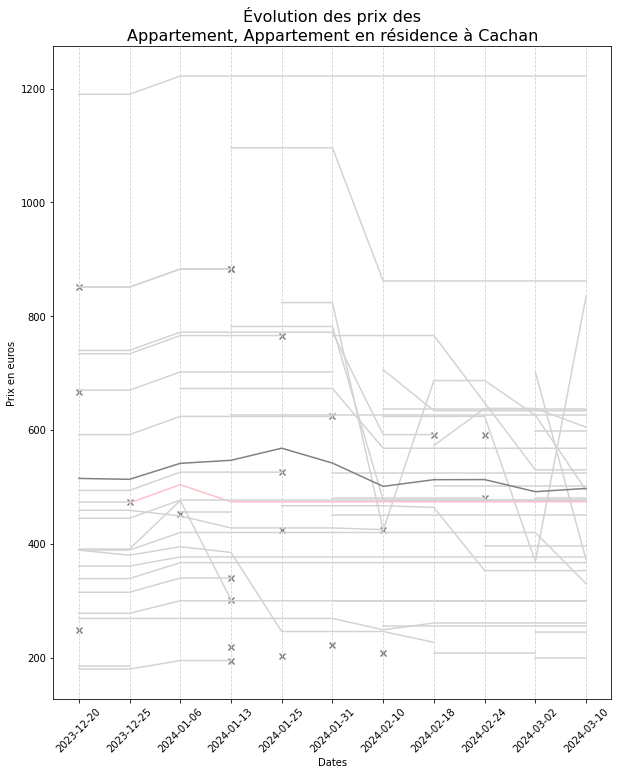

In [83]:
ville = 'Cachan'
types = ('Appartement', 'Appartement en résidence')

vue = pivot.reset_index()\
    .query(f"ville == '{ville}'")\
    .query(f"type in {types}")\
    .filter(regex='202|description')
cols = vue.columns

plt.figure(figsize=(10, 12))
for tup in vue.itertuples():
    y = [getattr(tup, f'_{i}') for i in range(2, len(tup))]
    color = 'pink' if tup.description == ma_description else 'lightgrey'
    plt.plot(y, color=color)
    # Une croix pour les loués :
    loué = pd.isna(tup[-2]) and pd.isna(tup[-1])
    if loué:
        date, dernier_montant_non_nul = [mt for mt in enumerate(y) if pd.notna(mt[1])][-1]
        plt.scatter(x=date, y=dernier_montant_non_nul, marker="x", color='gray')
plt.plot(vue.drop('description', axis=1).mean().values, color='gray', label='mean')
plt.xticks(range(len(cols) - 1), cols[1:], rotation=45)
plt.ylabel('Prix en euros')
plt.xlabel('Dates')
plt.grid(axis='x', color='lightgrey', linestyle='--')
plt.title(f"Évolution des prix des\n{', '.join(types)} à {ville}", fontsize=16);

In [76]:
temp = vue.copy()
temp.columns = temp.columns.astype(str)
temp[temp['2023-12-20'] < 200]

,description,2023-12-20,2023-12-25,2024-01-06,2024-01-13,2024-01-25,2024-01-31,2024-02-10,2024-02-18,2024-02-24,2024-03-02,2024-03-10
22,appartement t1 indépendant. (ga),180.0,180.0,195.0,195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,Appartement La Maison Blanche,185.0,185.0,NaN,200.0,NaN,200.0,NaN,NaN,NaN,200.0,200.0


## Annexes

In [122]:
# Recherche d'une clé primaire : 
variables_dynamiques = ['date_enregistrement', 'est_nouveau', 'note', 'nb_avis']
vue = df.drop(variables_dynamiques, axis=1).drop_duplicates()
vue[vue[clé].duplicated(keep=False)]

# --> les logements qui apparaissent sont ceux qui ont changé de stratégie de prix !
# --> la clé ['ville', 'type', 'description'] identifie donc un logement de façon unique

,type,ville,description,prix,nb_lits,nb_chambres,est_professionnel
41,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1425,NaN,NaN,False
57,Appartement,Cachan,2P a 10 min à pied du RER B,389,NaN,NaN,False
197,Appartement,Cachan,2P a 10 min à pied du RER B,380,NaN,NaN,False
239,Hébergement,Arcueil,La Maison Ensoleillée - 2 Chambres - RER B & M7,1355,NaN,NaN,False
